# Computed MAF QC

The goal of the analysis is to see how many lead variants from credible sets had correctly calculated MAF.

<div class="alert alert-block alert-info"> 
<b> Reasons of MAF computation failure </b>
    <ul>
        <li><I>majorPopulationMAF == 0.0</I>  - Searched variant was found in gnomAD, but it was not reported for the searched study major population</li>
        <li><I>majorPopulationMAF is Null</I> -  Searched variant was not found in gnomAD, so AF was not reported for any population</li>
    </ul>

 </div>


## Data Loading

The data required for the analysis is loaded from the `computed maf` dataset.


In [1]:
from gentropy.common.session import Session
from pyspark.sql import functions as f

from manuscript_methods.datasets import LeadVariantEffect


Loading BokehJS ...

In [2]:
session = Session(extended_spark_conf={"spark.driver.memory": "40G"})
lead_maf_dataset_path = "../../data/lead-maf-vep"


25/06/23 11:46:45 WARN Utils: Your hostname, mindos resolves to a loopback address: 127.0.1.1; using 192.168.0.100 instead (on interface eno1)
25/06/23 11:46:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/23 11:46:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/23 11:46:46 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/23 11:46:46 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
session.spark


In [4]:
dataset_maf = LeadVariantEffect.from_parquet(session, lead_maf_dataset_path)


## MAF QC

Ensure that both datasets contain the same amount of rows

<img src="plots/01.2_discrepancies_in_maf_calculation.jpg" width="600">


In [9]:
from manuscript_methods import group_statistics, plot_group_statistics
from manuscript_methods.maf import maf_discrepancies

data = dataset_maf.df.select(maf_discrepancies(f.col("majorLdPopulationMaf.value")))

gs = group_statistics(data, f.col("mafDiscrepancy"))
gs.show()


+--------------------+-------+-----+
|      mafDiscrepancy|  count|    %|
+--------------------+-------+-----+
|Variant has allel...|2821580|99.57|
|Variant missing f...|   9434| 0.33|
|Variant missing f...|   2744| 0.10|
+--------------------+-------+-----+



### Plot

/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5.35 x 4.5 in image.
/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/01.2_discrepancies_in_maf_calculation.jpg


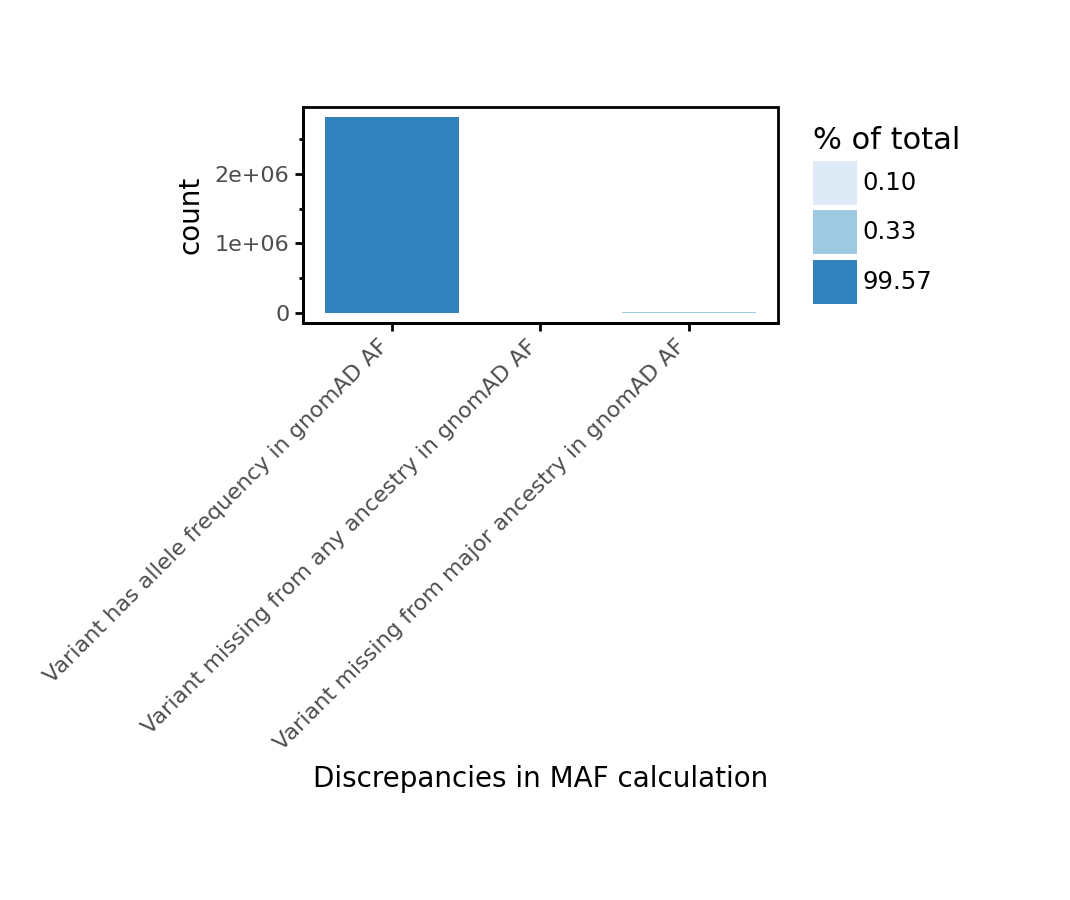

In [10]:
plot = plot_group_statistics(gs, x="mafDiscrepancy", y="count", fill="%", title="Discrepancies in MAF calculation")
plot.save("plots/01.2_discrepancies_in_maf_calculation.jpg", dpi=300, bbox_inches="tight")

plot


## Common vs Rare

The analysis was performed to see how many lead variants are falling into
* common (MAF > 0.01) and rare (MAF < 0.01) categories.

The analysis was perfromed on all credible set studyTypes

### Prepare the data

In [5]:
from manuscript_methods.maf import MinorAlleleFrequency, MinorAlleleFrequencyClassification


In [6]:
# Filter dataset to only include variants with a valid MAF value
filtered_maf_dataset = dataset_maf.maf_filter()

# Classify the minor allele frequency to common and rare variants
maf = MinorAlleleFrequency(f.col("majorLdPopulationMaf"))
maf_classification = MinorAlleleFrequencyClassification.from_maf(maf)
classified_dataset_maf = (
    filtered_maf_dataset.df.withColumn(maf_classification.name, maf_classification.col)
    .select("variantMAFClassification.*", "variantId", "studyStatistics.studyType")
    .melt(
        ids=["variantId", "studyType"],
        values=["common", "rare"],
        variableColumnName="mafClass",
        valueColumnName="mafValue",
    )
    .filter(f.col("mafValue"))
    .drop("mafValue")
)


### Check the number of common vs rare variants in all credible sets

In [ ]:
import plotnine as pn

from manuscript_methods import group_statistics


In [9]:
gs = group_statistics(classified_dataset_maf, [f.col("mafClass"), f.col("studyType")])
gs.show()


+--------+----------+-------+-----+
|mafClass| studyType|  count|    %|
+--------+----------+-------+-----+
|  common|      eqtl|1294844|45.89|
|  common|      gwas| 679900|24.10|
|  common|     tuqtl| 371699|13.17|
|  common|      sqtl| 216793| 7.68|
|    rare|      gwas|  98290| 3.48|
|    rare|      eqtl|  54024| 1.91|
|  common|    sceqtl|  51939| 1.84|
|  common|trans-pqtl|  15826| 0.56|
|    rare|     tuqtl|  13066| 0.46|
|  common|  cis-pqtl|  11864| 0.42|
|    rare|      sqtl|   6659| 0.24|
|    rare|  cis-pqtl|   4069| 0.14|
|    rare|trans-pqtl|   1822| 0.06|
|    rare|    sceqtl|    785| 0.03|
+--------+----------+-------+-----+



/home/mindos/Projects/OpenTargets/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/guides/guides.py:211: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


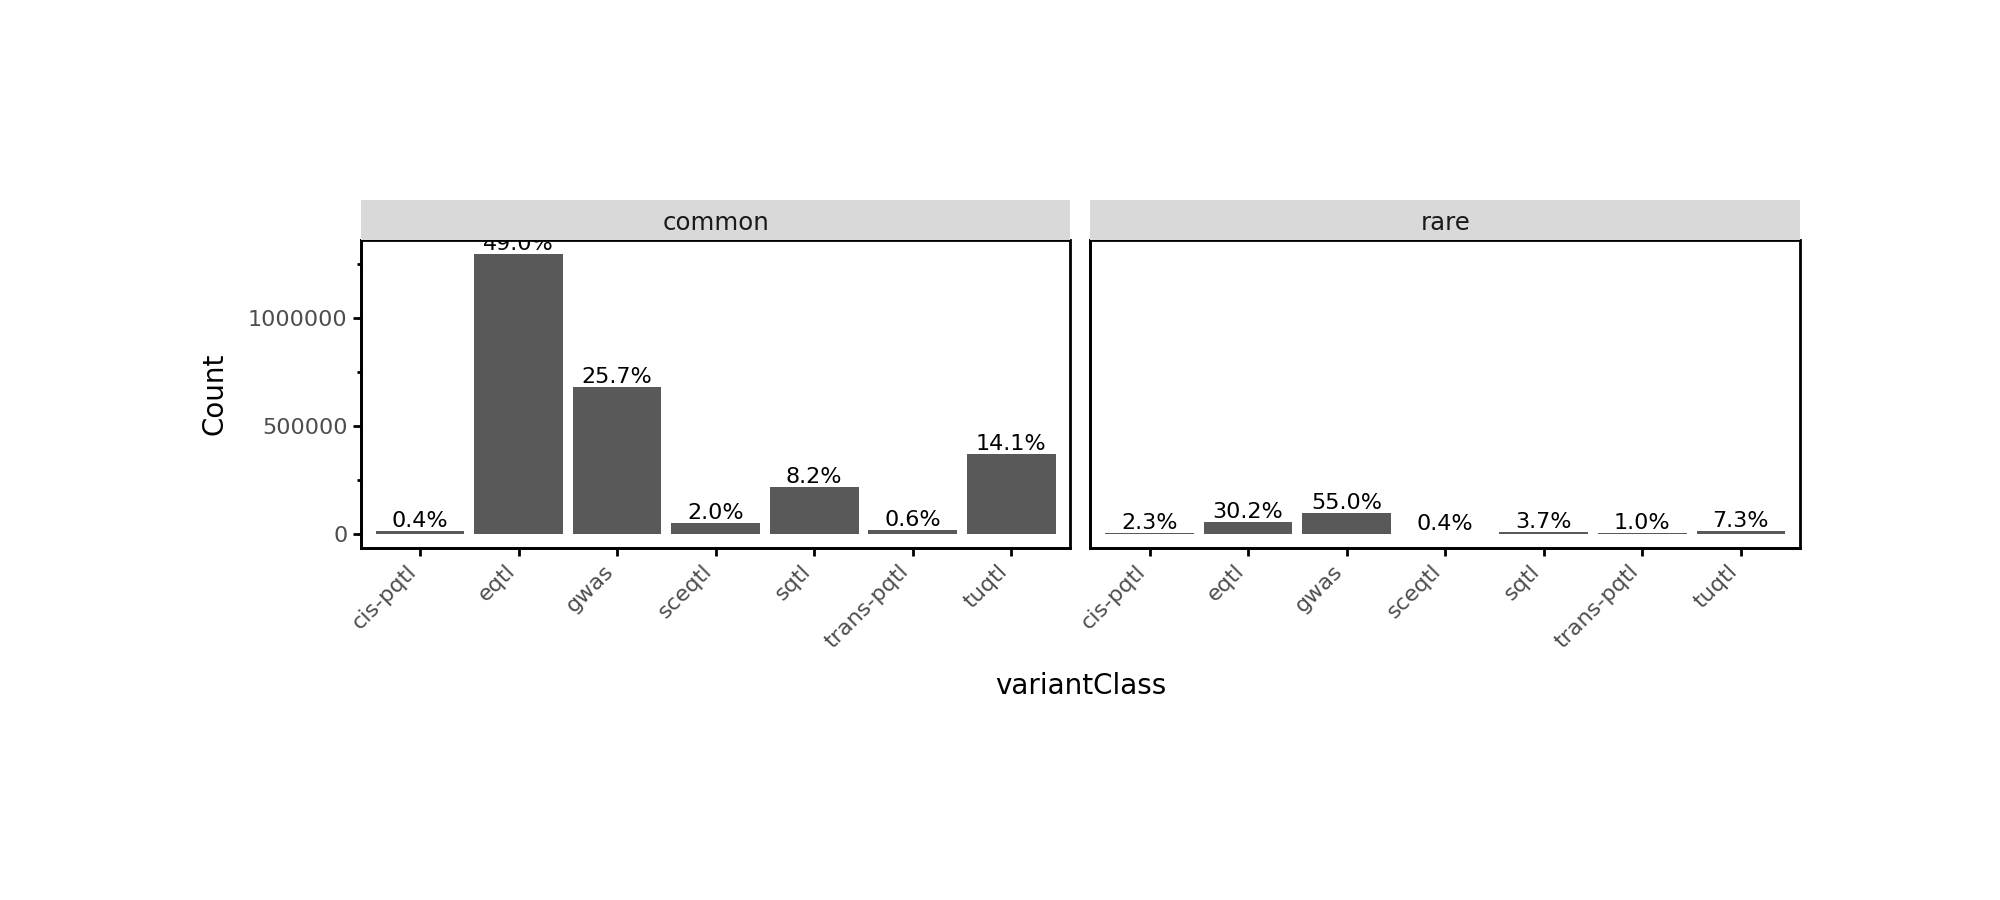

In [22]:
data = classified_dataset_maf.toPandas()
REM = 10
# This plot works on non-aggregated data, all aggregations are done by plotnine
plt = (
    pn.ggplot(data, pn.aes(x="studyType"))
    + pn.geom_bar()
    + pn.facet_grid(cols="mafClass")
    + pn.labs(x="variantClass", y="Count")
    + pn.scale_fill_brewer()
    + pn.theme(
        figure_size=(10, 4.5),  # ~85mm wide
        axis_title=pn.element_text(size=REM * 1, family="sans-serif"),
        axis_text=pn.element_text(size=REM * 0.8, family="sans-serif"),
        axis_text_x=pn.element_text(rotation=45, hjust=1),
        axis_ticks=pn.element_line(color="black"),
        axis_line=pn.element_line(color="black"),
        panel_background=pn.element_rect(fill="white"),
        panel_border=pn.element_rect(color="black", fill=None),
        panel_grid=pn.element_blank(),
        plot_margin=0.1,
    )
    + pn.geom_text(
        pn.aes(label=pn.after_stat("prop*100"), group=1),
        stat="count",
        position=pn.position_dodge(width=0.9),
        size=8,
        va="bottom",
        format_string="{:.1f}%",
    )
)
plt
